# [FisheryApp_ML](https://github.com/FisheryBangkit/FisheryApp_ML.git)

In [1]:
#Import semua framework dan library yang dibutuhkan
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import GlobalAveragePooling2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import os


# **Memindahkan folder ke working**

In [2]:
path_folder_input = '/kaggle/input/tilapia-fish-diseasev2/dataset'
path_working = '/kaggle/working/'
shutil.move(path_folder_input, path_working)

OSError: [Errno 30] Read-only file system: 'R (2).jpg'

In [3]:
nama_folder_baru = 'validation'
path_folder_baru = os.path.join('/kaggle/working/dataset', nama_folder_baru)
os.makedirs(path_folder_baru)

nama_folder_baru = 'aeromonas_infection'
path_folder_baru = os.path.join('/kaggle/working/dataset/validation', nama_folder_baru)
os.makedirs(path_folder_baru)

nama_folder_baru = 'sehat'
path_folder_baru = os.path.join('/kaggle/working/dataset/validation', nama_folder_baru)
os.makedirs(path_folder_baru)

nama_folder_baru = 'white_spot'
path_folder_baru = os.path.join('/kaggle/working/dataset/validation', nama_folder_baru)
os.makedirs(path_folder_baru)

# Melakukan Data Split Sebanyak 20% untuk Validasi

In [4]:
#randomize data dari training lalu pindahkan 20%nya ke validation
import random
# Fungsi
def randomize_move_files(folder_sumber, folder_tujuan, persentase_pindah):
    files = os.listdir(folder_sumber)
    
    jumlah_file_diambil = int(persentase_pindah * len(files))
    
    files_yang_diambil = random.sample(files, jumlah_file_diambil)

    # Pindahkan file-file yang terpilih ke folder tujuan
    for file in files_yang_diambil:
        path_file_sumber = os.path.join(folder_sumber, file)
        path_file_tujuan = os.path.join(folder_tujuan, file)
        shutil.move(path_file_sumber, path_file_tujuan)
        
    print(f"{jumlah_file_diambil} file telah dipindahkan ke '{folder_tujuan}'")

#pindahkan data ikan terinfeksi aeromonas ke validasi 20%
folder_sumber = '/kaggle/working/dataset/training/aeromonas_infection'
folder_tujuan = '/kaggle/working/dataset/validation/aeromonas_infection'
jumlah = 0.2
randomize_move_files(folder_sumber, folder_tujuan, jumlah)

#pindahkan data ikan terinfeksi whitespot ke validasi 20%
folder_sumber = '/kaggle/working/dataset/training/white_spot'
folder_tujuan = '/kaggle/working/dataset/validation/white_spot'
jumlah = 0.2
randomize_move_files(folder_sumber, folder_tujuan, jumlah)

#pindahkan data ikan sehat ke validasi 20%
folder_sumber = '/kaggle/working/dataset/training/sehat'
folder_tujuan = '/kaggle/working/dataset/validation/sehat'
jumlah = 0.2
randomize_move_files(folder_sumber, folder_tujuan, jumlah)
    

102 file telah dipindahkan ke '/kaggle/working/dataset/validation/aeromonas_infection'
104 file telah dipindahkan ke '/kaggle/working/dataset/validation/white_spot'
121 file telah dipindahkan ke '/kaggle/working/dataset/validation/sehat'


# Labeling dan Augmentasi Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/kaggle/working/dataset/training"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/kaggle/working/dataset/validation"
validation_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300,300),
    class_mode='categorical',
    batch_size=20
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300,300),
    class_mode='categorical',
    batch_size=10
)

Found 1312 images belonging to 3 classes.
Found 327 images belonging to 3 classes.


# Penggunaan Pre-trained Model InceptionV3 

In [6]:
import urllib.request
from urllib.request import urlopen
from tensorflow.keras.applications.inception_v3 import InceptionV3
    
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model =  InceptionV3(input_shape = (300, 300, 3),
                                  include_top = False,
                                  weights = None)
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer =   pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [7]:
# Mengatur Ouput Layer
x = GlobalAveragePooling2D()(last_output)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)
 
model = Model(pre_trained_model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

# Quantization

In [ ]:
#pakai kalau dibutuhkan (mengecilkan size, mengurangi akurasi)
#untuk code selanjutnya ganti "model" dengan "q_aware_model" 
# import tensorflow_model_optimization as tfmot

# q_aware_model = tf.keras.models.clone_model(model)
# q_aware_model = tfmot.quantization.keras.quantize_model(q_aware_model)

# **Pelatihan Model**

In [9]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 39,
                    validation_steps = 30,
                    epochs = 20,
                    verbose = 2
                    )

Epoch 1/20
39/39 - 114s - loss: 0.4348 - accuracy: 0.8756 - val_loss: 0.3831 - val_accuracy: 0.8767 - 114s/epoch - 3s/step
Epoch 2/20
39/39 - 122s - loss: 0.3800 - accuracy: 0.8912 - val_loss: 0.3791 - val_accuracy: 0.8600 - 122s/epoch - 3s/step
Epoch 3/20
39/39 - 121s - loss: 0.3156 - accuracy: 0.9054 - val_loss: 0.3243 - val_accuracy: 0.8733 - 121s/epoch - 3s/step
Epoch 4/20
39/39 - 122s - loss: 0.2860 - accuracy: 0.9218 - val_loss: 0.3153 - val_accuracy: 0.8800 - 122s/epoch - 3s/step
Epoch 5/20
39/39 - 108s - loss: 0.2721 - accuracy: 0.9210 - val_loss: 0.2685 - val_accuracy: 0.9067 - 108s/epoch - 3s/step
Epoch 6/20
39/39 - 121s - loss: 0.2672 - accuracy: 0.9223 - val_loss: 0.2731 - val_accuracy: 0.8967 - 121s/epoch - 3s/step
Epoch 7/20
39/39 - 110s - loss: 0.2379 - accuracy: 0.9397 - val_loss: 0.2522 - val_accuracy: 0.9067 - 110s/epoch - 3s/step
Epoch 8/20
39/39 - 122s - loss: 0.2384 - accuracy: 0.9321 - val_loss: 0.2534 - val_accuracy: 0.9000 - 122s/epoch - 3s/step
Epoch 9/20
39/39

# Menyimpan model dalam format .h5

In [ ]:
nama_folder_baru = 'saved_model'
path_folder_baru = os.path.join('/kaggle/working/', nama_folder_baru)
os.makedirs(path_folder_baru)

export_dir = '/kaggle/working/saved_model'
tf.saved_model.save(model, export_dir)

model.save("model.h5")

# Konversi Model ke format tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('tilapia_disease_detec.tflite')
tflite_model_file.write_bytes(tflite_model)

In [ ]:
from IPython.display import FileLink

FileLink(r'model.h5')

In [ ]:
FileLink(r'tilapia_disease_detec.tflite')

# Test

In [ ]:
from PIL import Image
from io import BytesIO
import IPython.display as display
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50, decode_predictions

# Fungsi untuk membaca dan menampilkan gambar
def read_and_display_image(image_path):
    img = Image.open(image_path)
    display.display(img)
    return np.array(img)

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(300, 300))  # Sesuaikan dengan ukuran input model
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array



In [ ]:
# Proses gambar dan lakukan prediksi
image_path = '/kaggle/input/testing/ikan_sehat.jpg'

processed_image = preprocess_image(image_path)
prediction = model.predict(processed_image)
print("Dimensi hasil prapemrosesan:", prediction)

In [ ]:


images, labels = train_generator.next()
print("Labels:", labels)

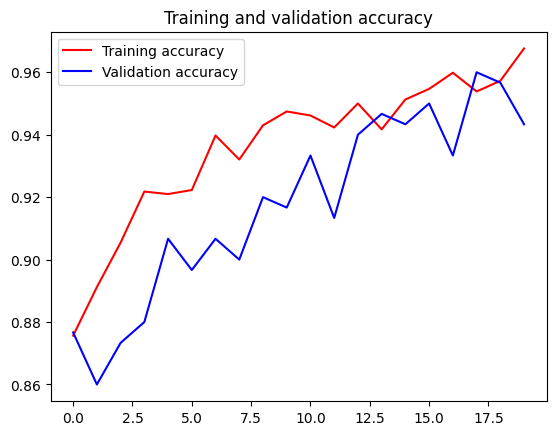

<Figure size 640x480 with 0 Axes>

In [10]:
#plot
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()